In [0]:
import pandas as pd
import numpy as np
from gym.utils import seeding
import matplotlib.pyplot as plt
from collections import deque
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# Data import

In [4]:
import json
!kaggle config set -n path -v{/content}
!mkdir .kaggle
api_token ={"username":"skanderkaz","key":"80b99bdf67c3afd3b67c0129a46f2b5c"}

with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
    
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets download -d borismarjanovic/price-volume-data-for-all-us-stocks-etfs
!unzip \*.zip

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: Stocks/erh.us.txt       
  inflating: Stocks/eri.us.txt       
  inflating: Stocks/eric.us.txt      
  inflating: Stocks/erie.us.txt      
  inflating: Stocks/erii.us.txt      
  inflating: Stocks/erj.us.txt       
  inflating: Stocks/erm.us.txt       
  inflating: Stocks/ern.us.txt       
  inflating: Stocks/eros.us.txt      
  inflating: Stocks/eryp.us.txt      
  inflating: Stocks/es.us.txt        
  inflating: Stocks/esba.us.txt      
  inflating: Stocks/esbk.us.txt      
  inflating: Stocks/esca.us.txt      
  inflating: Stocks/esdi.us.txt      
  inflating: Stocks/esdiw.us.txt     
  inflating: Stocks/ese.us.txt       
  inflating: Stocks/esea.us.txt      
  inflating: Stocks/eses.us.txt      
  inflating: Stocks/esg.us.txt       
  inflating: Stocks/esgd.us.txt      
  inflating: Stocks/esge.us.txt      
  inflating: Stocks/esgf.us.txt      
  inflating: Stocks/esgg.us.txt      
  inflatin

In [5]:
data = pd.read_csv('Data/Stocks/googl.us.txt')
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index('Date')
print(data.index.min(), data.index.max())
data.head()

2004-08-19 00:00:00 2017-11-10 00:00:00


,Open,High,Low,Close,Volume,OpenInt
Date,,,,,,
2004-08-19,50.000,52.03,47.980,50.170,44703800,0
2004-08-20,50.505,54.54,50.250,54.155,22857200,0
2004-08-23,55.375,56.74,54.525,54.700,18274400,0
2004-08-24,55.620,55.80,51.785,52.435,15262600,0
2004-08-25,52.480,54.00,51.940,53.000,9197800,0


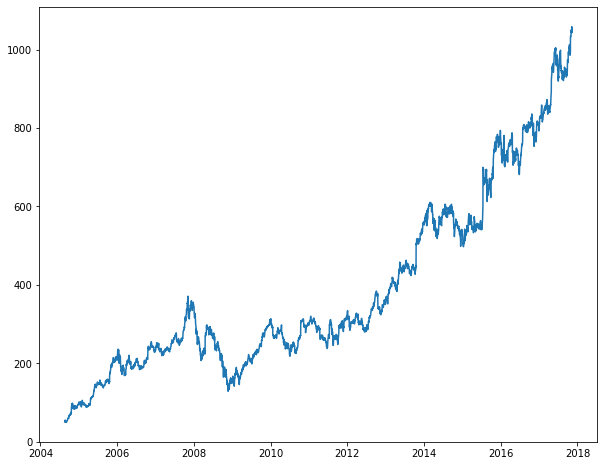

In [6]:
plt.figure(figsize=(10,8))
plt.plot(data['Close'])

In [7]:
start_date = '2013-01-01'
date_split = '2016-01-01'
data_train = data[start_date:date_split]
data_test = data[date_split:]
len(data_train), len(data_test)

(756, 470)

# DDQN :

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [9]:
device

device(type='cuda')

In [0]:
class DQN(nn.Module):
    def __init__(self, input_size, output_size, layer_size):
        super().__init__()
        self.l1 = torch.nn.Sequential(
        torch.nn.Linear(input_size, layer_size),
        torch.nn.ReLU(),
        torch.nn.Linear(layer_size, layer_size//2),
        torch.nn.ReLU(),
        torch.nn.Linear(layer_size//2, output_size),
        )

    def forward(self, input_seq):
        return self.l1(input_seq)
   
class DDQNAgent:

    LEARNING_RATE = 0.001
    BATCH_SIZE = 32
    LAYER_SIZE = 50
    OUTPUT_SIZE = 3
    epsilon = 1.0
    epsilon_min = 0.01
    epsilon_decay = 0.995
    GAMMA = 0.99
    MEMORIES = deque()
    TARGET_UPDATE = 10
    MEMORY_SIZE = 300
    
    def __init__(self, state_size, window_size, trend, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.model = DQN(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE).float().to(device)
        self.model_negative = DQN(self.state_size, self.OUTPUT_SIZE, self.LAYER_SIZE).float().to(device)
        self.optimizer = optim.Adam(self.model.parameters(), self.LEARNING_RATE)
        self.Loss = nn.MSELoss()
        self.transaction_cost = 0
        self.dict_actions = {0:0,1:1,2:-1}
    

    def _memorize(self, state, action, reward, new_state):
        self.MEMORIES.append((state, action, reward, new_state))
        if len(self.MEMORIES) > self.MEMORY_SIZE:
            self.MEMORIES.popleft()

    def _select_action(self, state):
        if np.random.rand() < self.epsilon:
            action = np.random.randint(self.OUTPUT_SIZE)
        else:
            action = self.get_predicted_action([state]).cpu().numpy()
        return action

    def _construct_memories(self, replay):
        states = np.array([a[0] for a in replay])
        new_states = np.array([a[3] for a in replay])
        Q = self.predict(states).detach().cpu()
        Q_new = self.predict(new_states).detach().cpu()
        Q_new_negative = self.model_negative(torch.tensor(new_states).float().to(device)).detach().cpu()
        replay_size = len(replay)
        X = np.empty((replay_size, self.state_size))
        Y = np.empty((replay_size, self.OUTPUT_SIZE))
        for i in range(replay_size):
            state_r, action_r, reward_r, new_state_r = replay[i]
            target = Q[i]
            target[action_r] = reward_r
            done_r = False
            if not done_r:
                target[action_r] += self.GAMMA * Q_new_negative[i, np.argmax(Q_new[i])]
            X[i] = state_r
            Y[i] = target
        return X, Y

    def predict(self, inputs):
        return self.model(torch.tensor(inputs).float().to(device))
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0].detach().cpu()
        return np.argmax(prediction)
    
    def get_state(self, t):
        window_size = self.window_size + 1
        d = t - window_size
        block = agent.trend[d : t ] if d >= 0 else -(d) * [agent.trend[0]] + agent.trend[0 : t ]
        res = []
        for i in range(window_size - 1):
            res.append(np.log(block[i + 1]) - np.log(block[i]))
        return np.array(res)
            
    
    def train(self, iterations, checkpoint):
        print(self.model)
        mean_losses_list = []
        gain_list = []
        mean_reward_list = []
        std_reward_list = []
        for i in range(iterations):
            state = self.get_state(1)
            losses_list = []
            reward_list = []
            for t in range(1, len(self.trend) - 1, self.skip):
                action = self._select_action(state)
                next_state = self.get_state(t + 1)
                reward = self.dict_actions[int(action)] * (np.log(self.trend[t]-self.dict_actions[int(action)]*self.transaction_cost)- np.log(self.trend[t-1])) 
                reward_list.append(reward)          
                self._memorize(state, action, reward, next_state)
                batch_size = min(len(self.MEMORIES), self.BATCH_SIZE)
                state = next_state
                replay = random.sample(self.MEMORIES, batch_size)
                X, Y = self._construct_memories(replay)
                Q = self.predict(X).cpu()
                # compute loss
                loss = self.Loss(Q, torch.tensor(Y, requires_grad=True))
                losses_list.append(loss.item())
                # Optimize the model
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if i % self.TARGET_UPDATE == 0:
                    self.model_negative.load_state_dict(self.model.state_dict())
        
                if self.epsilon > self.epsilon_min:
			              self.epsilon *= self.epsilon_decay

            gain_list.append(np.sum(reward_list))
            mean_reward_list.append(np.mean(reward_list))
            std_reward_list.append(np.std(reward_list))
            mean_losses_list.append(np.mean(losses_list))
            if (i+1) % checkpoint == 0:
                print('epoch: %d, gain: %f.3, std reward: %f.3, Qloss: %f.3'%(i + 1, gain_list[-1], std_reward_list[-1]
                                                                                  ,mean_losses_list[-1]))
        return gain_list, mean_reward_list, std_reward_list, mean_losses_list

In [13]:
close = data_train.Close.values.tolist()
window_size = 20
skip = 1
batch_size = 32
agent = DDQNAgent(state_size = window_size, 
              window_size = window_size, 
              trend = close, 
              skip = skip)

gain_list, mean_reward_list, std_reward_list, mean_losses_list = agent.train(iterations = 150, checkpoint = 10)

DQN(
  (l1): Sequential(
    (0): Linear(in_features=20, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=25, bias=True)
    (3): ReLU()
    (4): Linear(in_features=25, out_features=3, bias=True)
  )
)
epoch: 10, gain: 1.173891.3, std reward: 0.010544.3, Qloss: 0.000037.3
epoch: 20, gain: 1.433510.3, std reward: 0.013062.3, Qloss: 0.000065.3
epoch: 30, gain: 2.717496.3, std reward: 0.014097.3, Qloss: 0.000063.3
epoch: 40, gain: 3.111592.3, std reward: 0.012291.3, Qloss: 0.000045.3
epoch: 50, gain: 3.143974.3, std reward: 0.012438.3, Qloss: 0.000047.3
epoch: 60, gain: 3.014961.3, std reward: 0.012459.3, Qloss: 0.000044.3
epoch: 70, gain: 2.871679.3, std reward: 0.012535.3, Qloss: 0.000063.3
epoch: 80, gain: 3.127251.3, std reward: 0.012561.3, Qloss: 0.000062.3
epoch: 90, gain: 2.782786.3, std reward: 0.012228.3, Qloss: 0.000087.3
epoch: 100, gain: 2.847561.3, std reward: 0.012307.3, Qloss: 0.000046.3
epoch: 110, gain: 2.870175.3, std reward: 0.013

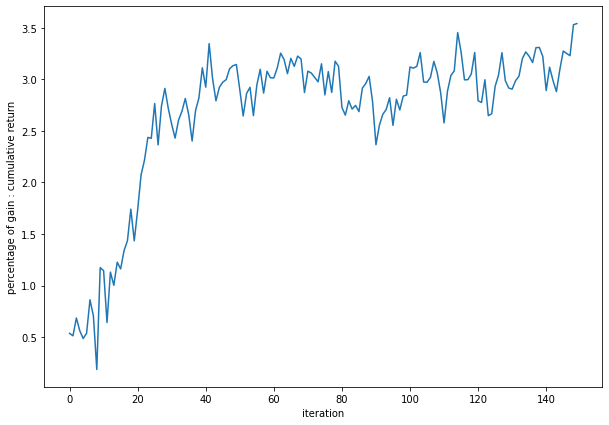

In [14]:
plt.figure(figsize=(10,7))
plt.plot(gain_list)
plt.xlabel("iteration")
plt.ylabel("percentage of gain : cumulative return")
plt.show()

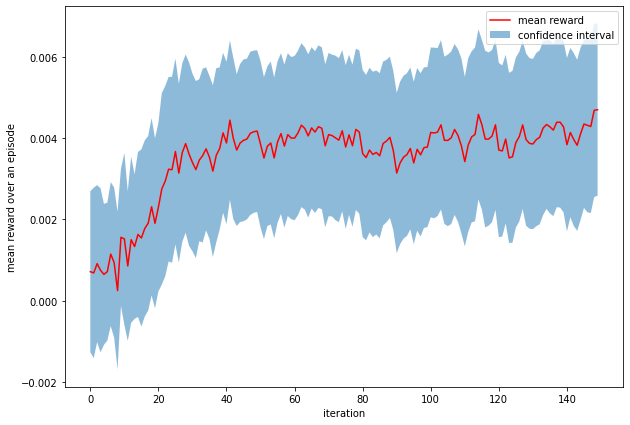

In [15]:
plt.figure(figsize=(10,7))
plt.fill_between([i for i in range(len(mean_reward_list))],
                 [mean_reward_list[i]+(1.96*std_reward_list[i])/np.sqrt(len(mean_reward_list)) for i in range(len(mean_reward_list))]
                 , [mean_reward_list[i]-(1.96*std_reward_list[i])/np.sqrt(len(mean_reward_list)) for i in range(len(mean_reward_list))]
                 ,alpha=0.5, label="confidence interval")
plt.plot(mean_reward_list, color="r", label="mean reward")
plt.xlabel("iteration")
plt.ylabel("mean reward over an episode")
plt.legend()
plt.show()

In [0]:
def trade_agent(agent, data):
    agent.trend = data
    state = agent.get_state(1)
    rewards_list = []
    actions_list = []
    for t in range(1, len(agent.trend) - 1, agent.skip):
        action = agent._select_action(state)
        actions_list.append(action)
        next_state = agent.get_state(t + 1)
        reward = agent.dict_actions[int(action)] * (np.log(agent.trend[t]-agent.dict_actions[int(action)]*agent.transaction_cost)- np.log(agent.trend[t-1])) 
        rewards_list.append(reward)
        state = next_state
    return rewards_list, actions_list

## test on train data

In [0]:
r_list, actions_list = trade_agent(agent, close)

Text(0.5, 0, 'days')

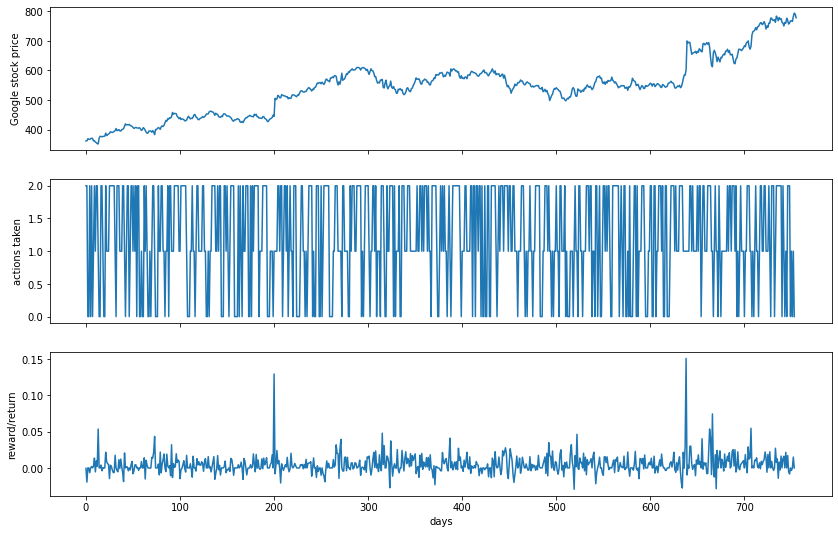

In [40]:
fig,ax = plt.subplots(3,1, figsize=(14,9), sharex=True)
ax[0].plot(close)
ax[1].plot(actions_list)
ax[2].plot(r_list)
ax[0].set_ylabel("Google stock price")
ax[1].set_ylabel("actions taken")
ax[2].set_ylabel("reward/return")
ax[2].set_xlabel("days")

In [0]:
close_r = [np.log(close[i + 1]) - np.log(close[i]) for i in range(len(close)-1)]

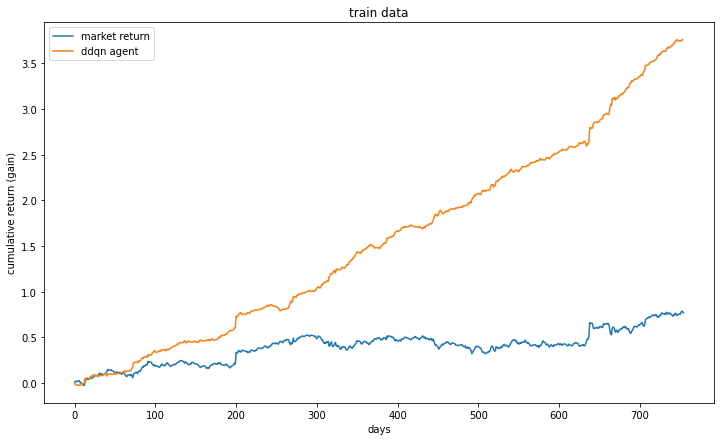

In [28]:
plt.figure(figsize=(12,7))
plt.title("train data")
plt.plot(np.cumsum(close_r), label="market return")
plt.plot(np.cumsum(r_list), label="ddqn agent")
plt.ylabel("cumulative return (gain)")
plt.xlabel("days")
plt.legend()

## test on test data

In [0]:
close_test = data_test.Close.values.tolist()
close_test_r = [np.log(close_test[i + 1]) - np.log(close_test[i]) for i in range(len(close_test)-1)]

In [0]:
r_list_test, actions_list = trade_agent(agent, close_test)

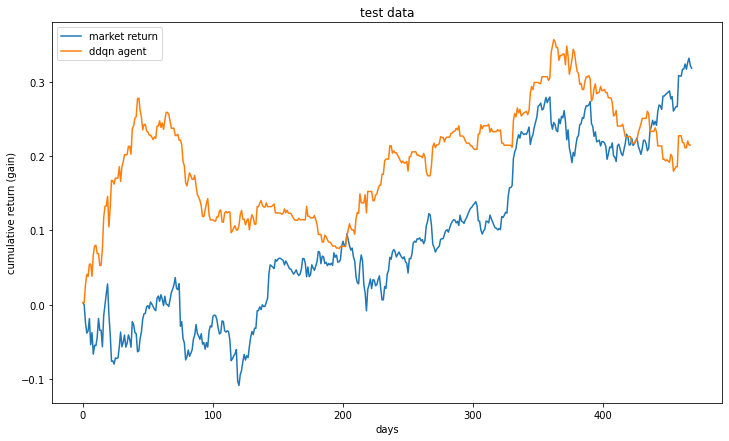

In [35]:
plt.figure(figsize=(12,7))
plt.title("test data")
plt.plot(np.cumsum(close_test_r), label="market return")
plt.plot(np.cumsum(r_list_test), label="ddqn agent")
plt.ylabel("cumulative return (gain)")
plt.xlabel("days")
plt.legend()